# Random Forest Regressor

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
from tree_models import decision_tree_regressor
%matplotlib inline
plt.style.use('seaborn')

In [2]:
class random_forest_regressor:
    
    def __init__(self, n_trees = 10, max_depth=None, n_features='sqrt', mode='rfnode', seed=None, criteria='std'):
        """
        Random Forest Regressor uses bootstrapping and column randomization
        to generate n_trees different datasets and then applies a decision 
        tree to each dataset. The final prediction is an ensemble of all created trees.
        ---
        Params:
        n_trees (int): number of bootstrapped trees to grow for ensembling
        max_depth (int): maximum number of splits to make in the tree
        mode: If mode='rfnode' the column randomization happens at each node. Otherwise
              the tree will assume all input columns are valid choices and randomize at
              a "per tree" level.
        n_features: The number of columns to include in the models. Only applies if
                    mode='rfnode.' Otherwise n_features = number of columns in data.
                    Options: numeric value (e.g. 4 => 4 columns used)
                             "sqrt" (square root of the number of cols in input data)
                             "div3" (number of input cols divided by 3)
        criteria: Options are "std" (standard deviation) and "mae" (absolute error from mean). 
                  This choice decides how the tree will be optimized. Default: "std"
        seed: Random seed to allow for reproducibility.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.n_features = n_features
        self.tree_filter_pairs = []
        self.mode = mode
        self.criteria = criteria
        if seed:
            self._seed = seed
            np.random.seed(seed)
        
    def find_number_of_columns(self, X):
        """
        Uses the user input for n_features to decide how many columns should
        be included in each model. Uses the shape of X to decide the final number
        if 'sqrt' is called. 
        ---
        Input: X (array, dataframe, or series)
        """
        if isinstance(self.n_features, int):
            return self.n_features
        if self.n_features == 'sqrt':
            return int(np.sqrt(X.shape[1])+0.5)
        if self.n_features == 'div3':
            return int(X.shape[1]/3+0.5)
        else:
            raise ValueError("Invalid n_features selection")
    
    def get_bagged_data(self, X, y):
        """
        Chooses random rows to populate a bootstrapped dataset, with replacement.
        Maintains the correlation between X and y
        ---
        Input: X, y (arrays)
        Outputs: randomized X,y (arrays)
        """
        index = np.random.choice(np.arange(len(X)),len(X))
        return X[index], y[index]
    
    def randomize_columns(self,X):
        """
        Chooses a set of columns to keep from the input data. These are
        randomly drawn, according the number requested by the user. The data
        is filtered and only the allowed columns are returned, along with the
        filter. 
        ---
        Input: X (array)
        Output: filtered_X (array), filter (array)
        """
        num_col = self.find_number_of_columns(X)
        filt = np.random.choice(np.arange(0,X.shape[1]),num_col,replace=False)
        filtered_X = self.apply_filter(X, filt)
        return filtered_X, filt
    
    def apply_filter(self, X, filt):
        """
        Given X and a filter, only the columns matching the index values
        in filter are returned.
        ---
        Input: X (array), filter (array of column IDs)
        Output: filtered_X (array)
        """
        filtered_X = X.T[filt]
        return filtered_X.T
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
        
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def fit(self, X, y):
        """
        Generates the bootstrapped data, decides which column to keep,
        and then uses the decision tree class to build a model on each 
        bootstrapped and column-randomized dataset. Each tree is stored 
        as part of the model for later use, along with the appropriate
        filter - which is needed to filter new data for use with the model.
        ---
        Input: X, y (arrays, dataframe, or series)
        """
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
        try:
            self.base_filt = [x for x in range(X.shape[1])]
        except IndexError:
            self.base_filt = [0]
        for _ in range(self.n_trees):
            filt = self.base_filt
            bagX, bagy = self.get_bagged_data(X,y)
            if self.mode == 'rftree':
                bagX, filt = self.randomize_columns(bagX)
            new_tree = decision_tree_regressor(self.max_depth, mode=self.mode, 
                                               n_features=self.n_features, criteria=self.criteria)
            new_tree.fit(bagX, bagy)
            self.tree_filter_pairs.append((new_tree, filt))
    
    def predict(self, X):
        """
        Uses the list of tree models built in the fit, doing a predict with each
        model. The associated filter is applied to X, so the model sees the columns
        it has learned about. The final prediction uses the mode of all the trees 
        predictions.
        ---
        Input: X (array, dataframe, or series)
        Output: Class ID (int)
        """
        X = self.convert_to_array(X)
        self.predicts = []
        for tree, filt in self.tree_filter_pairs:
            filtered_X = self.apply_filter(X, filt)
            self.predicts.append(tree.predict(filtered_X))
        self.pred_by_row = np.array(self.predicts).T
        
        ensemble_predict = []
        for row in self.pred_by_row:
            ensemble_predict.append(np.mean(row))
        return ensemble_predict
    
    def score(self, X, y):
        """
        Uses the predict method to measure the (negative)
        mean squared error of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: negative mean squared error (float)
        """
        pred = self.predict(X)
        return -1.* np.mean((np.array(pred)-np.array(y))**2)

# Load data

In [3]:
df=pd.DataFrame()
df = pd.read_csv('PPC_Bag_DailySales.csv')
columns = ['Date','Quantity In Quintal']
df = pd.DataFrame(df.values,columns=columns)

In [4]:
df.tail()

,Date,Quantity In Quintal
450,452.0,1198.425
451,453.0,1198.425
452,454.0,1188.425
453,455.0,1188.425
454,456.0,1199.925


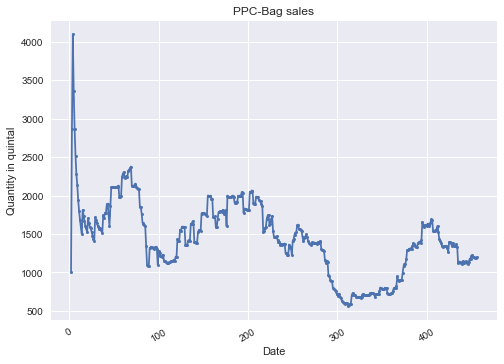

In [5]:
plt.plot(df['Date'], df['Quantity In Quintal'], '-o', markersize=3, label='true')
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('Quantity in quintal')
plt.title('PPC-Bag sales')
plt.show()

In [6]:
df['Quintal_LastDay']=df['Quantity In Quintal'].shift(+1)
df['Quintal_2Dayssback']=df['Quantity In Quintal'].shift(+2)
df['Quintal_3Dayssback']=df['Quantity In Quintal'].shift(+3)
df['Quintal_4Dayssback']=df['Quantity In Quintal'].shift(+4)
df['Quintal_5Dayssback']=df['Quantity In Quintal'].shift(+5)
df['Quintal_6Dayssback']=df['Quantity In Quintal'].shift(+6)
df['Quintal_7Dayssback']=df['Quantity In Quintal'].shift(+7)
df

,Date,Quantity In Quintal,Quintal_LastDay,Quintal_2Dayssback,Quintal_3Dayssback,Quintal_4Dayssback,Quintal_5Dayssback,Quintal_6Dayssback,Quintal_7Dayssback
0,2.0,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,2866.666667,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,4100.000000,2866.666667,1000.000000,NaN,NaN,NaN,NaN,NaN
3,5.0,3360.000000,4100.000000,2866.666667,1000.000000,NaN,NaN,NaN,NaN
4,6.0,2866.666667,3360.000000,4100.000000,2866.666667,1000.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
450,452.0,1198.425000,1228.425000,1218.425000,1178.425000,1178.425,1138.425,1113.425,1128.425
451,453.0,1198.425000,1198.425000,1228.425000,1218.425000,1178.425,1178.425,1138.425,1113.425
452,454.0,1188.425000,1198.425000,1198.425000,1228.425000,1218.425,1178.425,1178.425,1138.425
453,455.0,1188.425000,1188.425000,1198.425000,1198.425000,1228.425,1218.425,1178.425,1178.425


In [7]:
df=df.dropna()
df

,Date,Quantity In Quintal,Quintal_LastDay,Quintal_2Dayssback,Quintal_3Dayssback,Quintal_4Dayssback,Quintal_5Dayssback,Quintal_6Dayssback,Quintal_7Dayssback
7,9.0,2133.333333,2275.000000,2514.285714,2866.666667,3360.000000,4100.000000,2866.666667,1000.000000
8,10.0,1940.000000,2133.333333,2275.000000,2514.285714,2866.666667,3360.000000,4100.000000,2866.666667
9,11.0,1800.000000,1940.000000,2133.333333,2275.000000,2514.285714,2866.666667,3360.000000,4100.000000
10,12.0,1683.333333,1800.000000,1940.000000,2133.333333,2275.000000,2514.285714,2866.666667,3360.000000
11,13.0,1584.615385,1683.333333,1800.000000,1940.000000,2133.333333,2275.000000,2514.285714,2866.666667
...,...,...,...,...,...,...,...,...,...
450,452.0,1198.425000,1228.425000,1218.425000,1178.425000,1178.425000,1138.425000,1113.425000,1128.425000
451,453.0,1198.425000,1198.425000,1228.425000,1218.425000,1178.425000,1178.425000,1138.425000,1113.425000
452,454.0,1188.425000,1198.425000,1198.425000,1228.425000,1218.425000,1178.425000,1178.425000,1138.425000
453,455.0,1188.425000,1188.425000,1198.425000,1198.425000,1228.425000,1218.425000,1178.425000,1178.425000


In [8]:
x1,x2,x3,x4,x5,x6,x7,y=df['Quintal_LastDay'],df['Quintal_2Dayssback'],df['Quintal_3Dayssback'],df['Quintal_4Dayssback'],df['Quintal_5Dayssback'],df['Quintal_6Dayssback'],df['Quintal_7Dayssback'],df['Quantity In Quintal']
x1,x2,x3,x4,x5,x6,x7,y=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(x6),np.array(x7),np.array(y)
x1,x2,x3,x4,x5,x6,x7,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),x6.reshape(-1,1),x7.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3,x4,x5,x6,x7),axis=1)
print(final_x)

[[2275.       2514.285714 2866.666667 ... 4100.       2866.666667
  1000.      ]
 [2133.333333 2275.       2514.285714 ... 3360.       4100.
  2866.666667]
 [1940.       2133.333333 2275.       ... 2866.666667 3360.
  4100.      ]
 ...
 [1198.425    1198.425    1228.425    ... 1178.425    1178.425
  1138.425   ]
 [1188.425    1198.425    1198.425    ... 1218.425    1178.425
  1178.425   ]
 [1188.425    1188.425    1198.425    ... 1228.425    1218.425
  1178.425   ]]


### Split data for training and testing

In [9]:
train_size = int(len(final_x) * 0.80)
X_train,X_test,y_train,y_test=final_x[:train_size],final_x[train_size:],y[:train_size],y[train_size:]

In [10]:
rf = random_forest_regressor(n_trees=25, n_features='sqrt', mode='rfnode', seed=42)
rf.fit(X_train, y_train)

<ipython-input-2-69d152374620>:96: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
C:\Users\Sinte\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Sinte\anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\Sinte\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<ipython-input-2-69d152374620>:96: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):


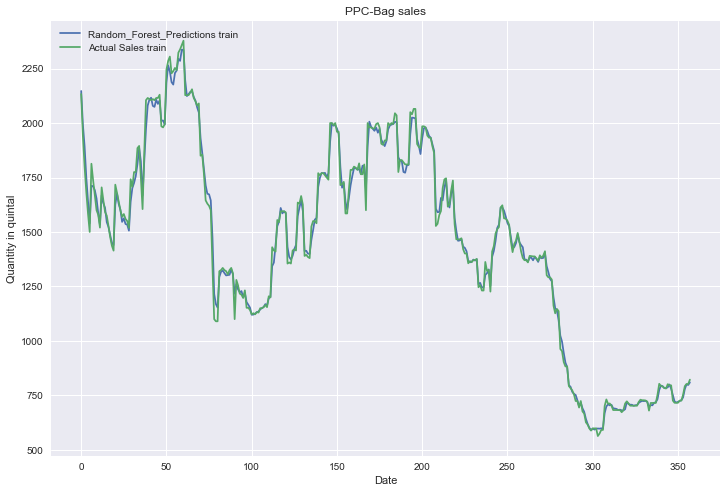

In [11]:
pred_train=rf.predict(X_train)

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred_train,label='Random_Forest_Predictions train')
plt.plot(y_train,label='Actual Sales train')
plt.xlabel('Date')
plt.ylabel('Quantity in quintal')
plt.title('PPC-Bag sales')
plt.legend(loc="upper left")
plt.show()

<ipython-input-2-69d152374620>:96: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):


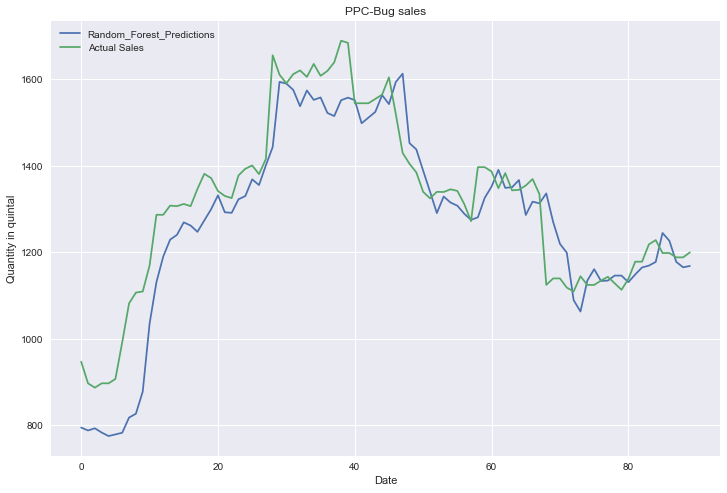

In [12]:
pred=rf.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.xlabel('Date')
plt.ylabel('Quantity in quintal')
plt.title('PPC-Bug sales')
plt.legend(loc="upper left")
plt.show()

### Calculating Mean Squared Error for linear regresssion

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y_test))

In [14]:
print('Mean Squared Error for Random Forest Model is:',rmse_rf)

Mean Squared Error for Random Forest Model is: 91.2355433234167


In [15]:
# calculate manually
d = y_test - pred
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)


print("Results by manual calculation:")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)


Results by manual calculation:
MAE: 236.19346572403956
MSE: 89628.27364631064
RMSE: 299.37981502818565
